In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Network analysis
from networkx.algorithms.flow import shortest_augmenting_path

# Set random seed for reproducibility
np.random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")




Libraries imported successfully!
Available CPU cores: 20
Available memory: 9.4 GB


In [2]:
# Load data from CSV file
print("Loading data from dataset.csv...")
try:
    edges_df = pd.read_csv('/home/algorithm/project/EvacuationPJ/dataset.csv')
    print(f"Successfully loaded {len(edges_df)} data  from dataset.csv")
    print(f"Columns: {list(edges_df.columns)}")
    print(f"Sample data:")
    print(edges_df.head())
except Exception as e:
    print(f"Error loading dataset.csv: {e}")
    edges_df = None

Loading data from dataset.csv...
Successfully loaded 533 data  from dataset.csv
Columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access']
Sample data:
          u           v  key      osmid  highway   name  oneway    ref  \
0  31253600  7092267898    0   23705307  primary  新大橋通り    True   50.0   
1  31253600    31253943    0   25824161  primary  新大橋通り    True   50.0   
2  31253776  9510994556    0  879780891  primary   海岸通り    True  316.0   
3  31253943  7092267898    0  894991906  primary   海岸通り    True  316.0   
4  31253982    31253943    0  894991907  primary   海岸通り    True  316.0   

   reversed     length                                           geometry  \
0     False  41.987798  LINESTRING (139.7635869 35.663609, 139.7634711...   
1     False  28.281910  LINESTRING (139.7635869 35.663609, 139.7634651...   
2     False  28.036136  LINESTRING (139.7634712 35.6646214, 139.7

In [3]:
# Process the loaded CSV data to create nodes and edges
if edges_df is not None:
    # Create nodes from unique source and target nodes
    unique_nodes = pd.unique(edges_df[['u', 'v']].values.ravel('K'))
    
    # Create nodes DataFrame with basic geometry (simplified coordinates)
    nodes_data = []
    for i, node_id in enumerate(unique_nodes):
        # For node ID
        nodes_data.append({
            'node_id': node_id,
        })
    
    nodes = pd.DataFrame(nodes_data).set_index('node_id')
    
    # Add random population to each node
    np.random.seed(42)  # For reproducible results
    num_nodes = len(nodes)
    
    # Generate random population for each node
    # Using different distribution strategies for variety
    residential_nodes = int(num_nodes * 0.6)  # 60% residential areas
    commercial_nodes = int(num_nodes * 0.25)  # 25% commercial areas
    industrial_nodes = num_nodes - residential_nodes - commercial_nodes  # 15% industrial/other
    
    populations = []
    
    # Residential areas: higher population (50-500 people per node)
    populations.extend(np.random.randint(50, 501, residential_nodes))
    
    # Commercial areas: moderate population (10-200 people per node)
    populations.extend(np.random.randint(10, 201, commercial_nodes))
    
    # Industrial/other areas: lower population (0-100 people per node)
    populations.extend(np.random.randint(0, 101, industrial_nodes))
    
    # Shuffle to randomize distribution across nodes
    np.random.shuffle(populations)
    
    # Assign population to nodes
    nodes['population'] = populations
    
    # Add node types for reference
    node_types = ['residential'] * residential_nodes + ['commercial'] * commercial_nodes + ['industrial'] * industrial_nodes
    np.random.shuffle(node_types)
    nodes['node_type'] = node_types
    
    # Calculate total population
    total_population = nodes['population'].sum()
    
    print(f"Population Distribution:")
    print(f"Total population across all nodes: {total_population:,}")
    print(f"Average population per node: {nodes['population'].mean():.1f}")
    print(f"Population range: {nodes['population'].min()} - {nodes['population'].max()}")
    print(f"\nNode type distribution:")
    print(nodes['node_type'].value_counts())
    print(f"\nPopulation by node type:")
    print(nodes.groupby('node_type')['population'].agg(['count', 'sum', 'mean']).round(1))
    
    # Process edges data
    edges = edges_df.copy()
    
    # Calculate basic edge properties
    edges['travel_time'] = edges['length'] / 50  # Assume 50 units per time unit
    edges['capacity'] = edges['length'] * 0.1  # Simple capacity based on length
    
    print(f"Network Statistics:")
    print(f"Number of nodes: {len(nodes)}")
    print(f"Number of edges: {len(edges)}")
    print(f"\nNodes columns: {list(nodes.columns)}")
    print(f"\nEdges columns: {list(edges.columns)}")
    
    # Display sample of processed data
    print(f"\nSample nodes:")
    print(nodes.head())
    print(f"\nSample edges:")
    print(edges[['u', 'v', 'length', 'travel_time', 'capacity']].head())
else:
    print("Cannot process data - edges_df is None")
    
# Define sink nodes for evacuation
SINK_NODE_1 = 31253600 
SINK_NODE_2 = 5110476586  
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self, nodes_df=None):
        # Update population based on loaded data

        self.total_population = nodes_df['population'].sum()
        self.total_households = int(self.total_population * 0.4)  # Approximate
        
        # Evacuation parameters
        self.time_step = 1  
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        # Capacity parameters
        self.road_capacity_per_meter = 1  # persons per meter of road width
        self.default_road_width = 5
        self.evacuation_time_limit = 360
        
params = EvacuationParameters(nodes)
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Time Steps: {params.time_step} minutes")


Population Distribution:
Total population across all nodes: 56,986
Average population per node: 202.8
Population range: 0 - 498

Node type distribution:
node_type
residential    168
commercial      70
industrial      43
Name: count, dtype: int64

Population by node type:
             count    sum   mean
node_type                       
commercial      70  12608  180.1
industrial      43   8183  190.3
residential    168  36195  215.4
Network Statistics:
Number of nodes: 281
Number of edges: 533

Nodes columns: ['population', 'node_type']

Edges columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access', 'travel_time', 'capacity']

Sample nodes:
          population    node_type
node_id                          
31253600         429  residential
31253776         130  residential
31253943         100   commercial
31253982         267  residential
31254273         100  residential

Sam

In [4]:
import re

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

# Extract node coordinates from the dataset
if edges_df is not None:
    print("Processing geometric data for mapping...")
    
    # Extract node coordinates
    node_coordinates = extract_node_coordinates(edges_df)
    print(f"Extracted coordinates for {len(node_coordinates)} nodes")
    
    # Add coordinates to nodes DataFrame
    if 'nodes' in locals() and nodes is not None:
        nodes['lat'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[0])
        nodes['lon'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[1])
        
        # Remove nodes without coordinates
        nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
        print(f"Nodes with valid coordinates: {len(nodes_with_coords)}")
    
    # Process edge geometries
    edges_df['coordinates'] = edges_df['geometry'].apply(parse_linestring)
    edges_with_geom = edges_df.dropna(subset=['coordinates'])
    print(f"Edges with valid geometry: {len(edges_with_geom)}")
    
    # Calculate bounding box for the map
    all_coords = []
    for coords_list in edges_with_geom['coordinates']:
        if coords_list:
            all_coords.extend(coords_list)
    
    if all_coords:
        lats = [coord[0] for coord in all_coords]
        lons = [coord[1] for coord in all_coords]
        
        center_lat = (min(lats) + max(lats)) / 2
        center_lon = (min(lons) + max(lons)) / 2
        
        print(f"Map bounds:")
        print(f"  Latitude: {min(lats):.6f} to {max(lats):.6f}")
        print(f"  Longitude: {min(lons):.6f} to {max(lons):.6f}")
        print(f"  Center: ({center_lat:.6f}, {center_lon:.6f})")
        
        # Store for map creation
        map_bounds = {
            'center': [center_lat, center_lon],
            'min_lat': min(lats),
            'max_lat': max(lats),
            'min_lon': min(lons),
            'max_lon': max(lons)
        }
    else:
        print("No valid coordinates found!")
else:
    print("No edge data available for processing")

Processing geometric data for mapping...
Extracted coordinates for 281 nodes
Nodes with valid coordinates: 281
Edges with valid geometry: 533
Map bounds:
  Latitude: 35.663554 to 35.675597
  Longitude: 139.758785 to 139.772396
  Center: (35.669575, 139.765590)


Creating static network visualization...


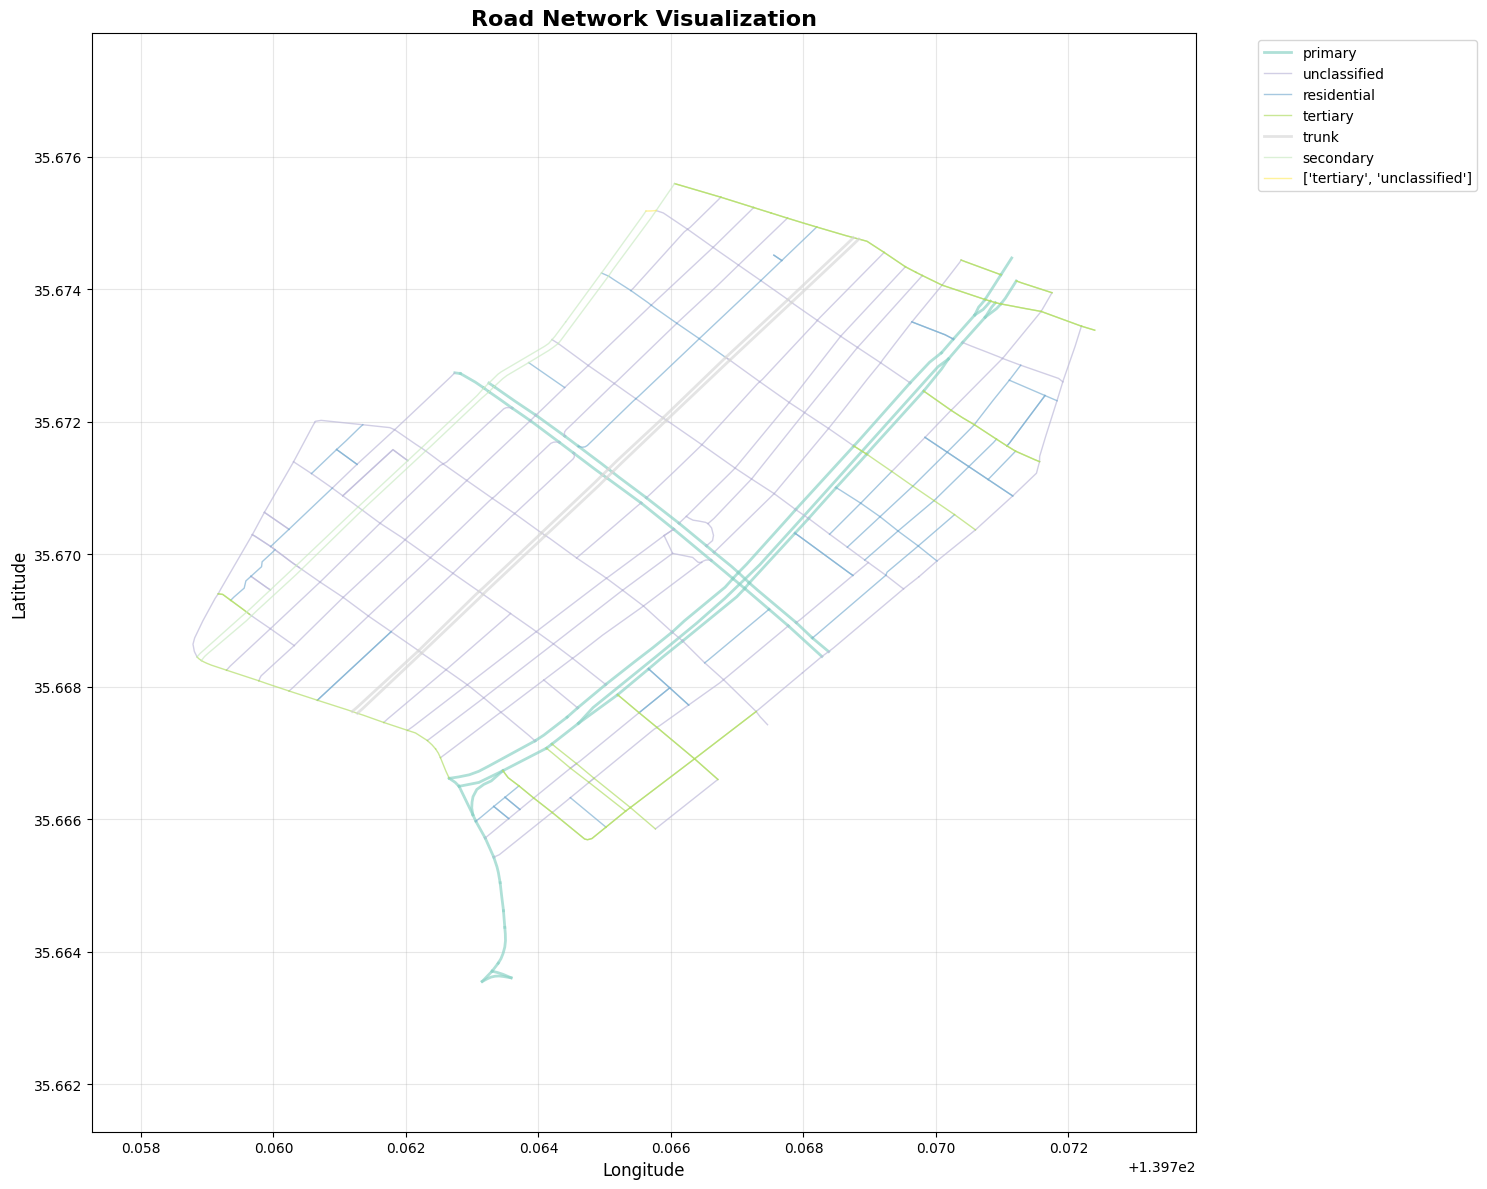

Static visualization created and saved


In [5]:
# Create static visualization with matplotlib
if 'map_bounds' in locals() and edges_with_geom is not None:
    print("Creating static network visualization...")
    
    plt.figure(figsize=(15, 12))
    
    # Create color map for different road types
    unique_highways = edges_with_geom['highway'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_highways)))
    highway_colors = dict(zip(unique_highways, colors))
    
    # Plot roads
    for highway_type in unique_highways:
        highway_edges = edges_with_geom[edges_with_geom['highway'] == highway_type]
        
        for idx, row in highway_edges.iterrows():
            coords = row['coordinates']
            if coords and len(coords) > 1:
                lats = [coord[0] for coord in coords]
                lons = [coord[1] for coord in coords]
                
                plt.plot(lons, lats, 
                        color=highway_colors[highway_type], 
                        linewidth=2 if highway_type in ['primary', 'trunk', 'motorway'] else 1,
                        alpha=0.7,
                        label=highway_type if idx == highway_edges.index[0] else "")
    
    # Customize plot
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Road Network Visualization', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Equal aspect ratio for geographic accuracy
    plt.axis('equal')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot

    plt.show()
    
    print("Static visualization created and saved")
else:
    print("Cannot create static visualization - missing data")

In [6]:
# Create NetworkX graph for network analysis
if edges_df is not None and 'node_coordinates' in locals():
    print("Creating NetworkX graph for network analysis...")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with coordinates
    for node_id, coords in node_coordinates.items():
        if coords[0] is not None and coords[1] is not None:
            G.add_node(node_id, lat=coords[0], lon=coords[1])
    
    # Add edges with attributes
    for idx, row in edges_df.iterrows():
        if row['u'] in G.nodes and row['v'] in G.nodes:
            G.add_edge(row['u'], row['v'], 
                      length=row['length'],
                      highway=row.get('highway', 'unknown'),
                      name=row.get('name', ''),
                      travel_time=row.get('travel_time', row['length']/50))
    
    print(f"NetworkX Graph Statistics:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Is connected: {nx.is_weakly_connected(G)}")
    print(f"  Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
    
    # Calculate basic network metrics
    if G.number_of_nodes() > 0:
        try:
            # Degree statistics
            degrees = dict(G.degree())
            avg_degree = sum(degrees.values()) / len(degrees)
            max_degree = max(degrees.values())
            
            print(f"  Average degree: {avg_degree:.2f}")
            print(f"  Maximum degree: {max_degree}")
            
            # Find nodes with highest degrees (important intersections)
            high_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"  Top 5 nodes by degree (major intersections):")
            for node, degree in high_degree_nodes:
                coords = node_coordinates.get(node, [None, None])
                print(f"    Node ID: {node} | Degree: {degree} | Coords: {coords}")
            
            # Show shelter nodes information
            print(f"  Shelter nodes information:")
            for shelter in [SINK_NODE_1, SINK_NODE_2]:  # SINK_NODE_1, SINK_NODE_2
                if shelter in G.nodes:
                    shelter_degree = degrees.get(shelter, 0)
                    shelter_coords = node_coordinates.get(shelter, [None, None])
                    # Add shelter capacity and mark this node as a shelter
                    G.nodes[shelter]['shelter_capacity'] = float('inf')  # Assuming infinite capacity for shelters
                    G.nodes[shelter]['is_shelter'] = True
                    print(f"    Shelter Node ID: {shelter} | Degree: {shelter_degree} | Coords: {shelter_coords}")
                else:
                    print(f"    Shelter Node ID: {shelter} | Status: NOT FOUND in network")
                
        except Exception as e:
            print(f"  Error calculating network metrics: {e}")
    
    # Store graph for later use
    road_network_graph = G
    print("NetworkX graph created successfully!")
else:
    print("Cannot create NetworkX graph - missing data")

Creating NetworkX graph for network analysis...
NetworkX Graph Statistics:
  Nodes: 281
  Edges: 533
  Is connected: True
  Number of weakly connected components: 1
  Average degree: 3.79
  Maximum degree: 8
  Top 5 nodes by degree (major intersections):
    Node ID: 1130958313 | Degree: 8 | Coords: [35.6669144, 139.7663559]
    Node ID: 1130958685 | Degree: 7 | Coords: [35.66761, 139.7655184]
    Node ID: 1130958910 | Degree: 6 | Coords: [35.6661036, 139.7642079]
    Node ID: 31255183 | Degree: 6 | Coords: [35.6740641, 139.7700922]
    Node ID: 1070638350 | Degree: 6 | Coords: [35.6738472, 139.7707411]
  Shelter nodes information:
    Shelter Node ID: 31253600 | Degree: 2 | Coords: [35.663609, 139.7635869]
    Shelter Node ID: 5110476586 | Degree: 1 | Coords: [35.6744743, 139.7711431]
NetworkX graph created successfully!


In [7]:
import folium
from shapely.geometry import LineString, Point
from shapely.wkt import loads
import re
from math import radians, cos, sin, asin, sqrt

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to calculate distance between two points
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on earth"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

print("Geometric processing functions defined successfully!")

Geometric processing functions defined successfully!


In [8]:
# Create enhanced map visualization with population data

if 'map_bounds' in locals() and edges_with_geom is not None and 'nodes' in locals():
    print("Creating enhanced map with population visualization...")
    
    # Create base map
    m = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Color coding for different road types
    road_colors = {
        'primary': '#FF6B6B',     # Red
        'secondary': '#4ECDC4',   # Teal
        'tertiary': '#45B7D1',    # Blue
        'residential': '#96CEB4', # Green
        'unclassified': '#FFEAA7', # Yellow
        'trunk': '#DDA0DD',       # Plum
        'motorway': '#FF7675',    # Light red
        'service': '#74B9FF'      # Light blue
    }
    
    # Add roads to map
    road_count = 0
    for idx, row in edges_with_geom.iterrows():
        coords = row['coordinates']
        if coords and len(coords) > 1:
            # Get road type and color
            highway_type = row.get('highway', 'unclassified')
            color = road_colors.get(highway_type, '#95A5A6')  # Default gray
            
            # Create popup text
            popup_text = f"""
            <b>Road Information</b><br>
            From Node: {row['u']}<br>
            To Node: {row['v']}<br>
            Highway Type: {highway_type}<br>
            Length: {row['length']:.1f}m<br>
            Name: {row.get('name', 'Unnamed')}<br>
            Max Speed: {row.get('maxspeed', 'N/A')}
            """
            
            # Add road as polyline
            folium.PolyLine(
                coords,
                color=color,
                weight=3 if highway_type in ['primary', 'trunk', 'motorway'] else 2,
                opacity=0.8,
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(m)
            
            road_count += 1
    
    # Add nodes with population data as circle markers
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    
    # Color mapping for node types
    node_type_colors = {
        'residential': '#2E8B57',  # Sea Green
        'commercial': '#FF4500',   # Orange Red
        'industrial': '#4169E1'    # Royal Blue
    }
    
    # Add population nodes to map
    for node_id, node_data in nodes_with_coords.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        node_type = node_data['node_type']
        
        # Scale circle size based on population (min 5, max 25)
        radius = max(5, min(25, population / 20))
        
        # Check if this is a shelter node
        is_shelter = node_id in [SINK_NODE_1, SINK_NODE_2]
        shelter_text = " (SHELTER)" if is_shelter else ""
        
        # Create popup with node information including Node ID
        popup_text = f"""
        <b>Node ID: {node_id}{shelter_text}</b><br>
        Type: {node_type.title()}<br>
        Population: {population:,}<br>
        Coordinates: ({lat:.6f}, {lon:.6f})<br>
        <small>Click to see Node ID: {node_id}</small>
        """
        
        # Special styling for shelter nodes
        if is_shelter:
            circle_color = '#FF0000'  # Red border for shelters
            fill_color = '#FFD700'    # Gold fill for shelters
            circle_weight = 3
            circle_radius = max(10, radius)  # Larger for shelters
        else:
            circle_color = 'black'
            fill_color = node_type_colors.get(node_type, '#808080')
            circle_weight = 1
            circle_radius = radius
        
        # Add circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=circle_radius,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Node ID: {node_id} | Pop: {population:,}{shelter_text}",
            color=circle_color,
            weight=circle_weight,
            fillColor=fill_color,
            fillOpacity=0.8 if is_shelter else 0.7
        ).add_to(m)
        
        # Add text label for shelter nodes and high-population nodes
        if is_shelter or population > 400:
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(
                    html=f'<div style="background-color: white; border: 1px solid black; border-radius: 3px; padding: 2px; font-size: 10px; font-weight: bold;">{node_id}</div>',
                    class_name='node-label'
                )
            ).add_to(m)
    
    print(f"Added {road_count} roads and {len(nodes_with_coords)} population nodes to the map")
    
    # Add enhanced legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 220px; height: 380px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Road Types</b><br>
    <i class="fa fa-minus" style="color:#FF6B6B"></i> Primary<br>
    <i class="fa fa-minus" style="color:#4ECDC4"></i> Secondary<br>
    <i class="fa fa-minus" style="color:#45B7D1"></i> Tertiary<br>
    <i class="fa fa-minus" style="color:#96CEB4"></i> Residential<br>
    <i class="fa fa-minus" style="color:#FFEAA7"></i> Unclassified<br>
    <i class="fa fa-minus" style="color:#DDA0DD"></i> Trunk<br>
    <i class="fa fa-minus" style="color:#74B9FF"></i> Service<br>
    <br>
    <b>Population Nodes</b><br>
    <i class="fa fa-circle" style="color:#2E8B57"></i> Residential<br>
    <i class="fa fa-circle" style="color:#FF4500"></i> Commercial<br>
    <i class="fa fa-circle" style="color:#4169E1"></i> Industrial<br>
    <i class="fa fa-circle" style="color:#FFD700; border: 2px solid red;"></i> Shelter Nodes<br>
    <br>
    <b>Shelter Information</b><br>
    <small>SINK_NODE_1: {sink1}<br>
    SINK_NODE_2: {sink2}</small><br>
    <br>
    <small>Circle size = Population<br>
    Total Population: {total_population:,}<br>
    <br>
    <b>Interaction:</b><br>
    • Click nodes for Node ID<br>
    • Hover for quick info<br>
    • Labels show for shelters</small>
    </div>
    '''.format(
        total_population=nodes['population'].sum(),
        sink1=SINK_NODE_1,
        sink2=SINK_NODE_2
    )
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Fit map to bounds
    m.fit_bounds([
        [map_bounds['min_lat'], map_bounds['min_lon']],
        [map_bounds['max_lat'], map_bounds['max_lon']]
    ])
    
    # Display the map
    display(m)
    

else:
    print("Cannot create enhanced map - missing data or coordinates")

Creating enhanced map with population visualization...
Added 533 roads and 281 population nodes to the map
Added 533 roads and 281 population nodes to the map


In [9]:
# Max Flow Analysis Implementation
from networkx.algorithms.flow import maximum_flow
from networkx.algorithms.flow import shortest_augmenting_path
import networkx.algorithms.flow as nxflow

class MaxFlowAnalyzer:
    def __init__(self, graph, shelter_nodes, capacity_attribute='capacity'):
        """
        Initialize the Max Flow Analyzer
        
        Args:
            graph: NetworkX graph
            shelter_nodes: List of shelter node IDs
            capacity_attribute: Name of edge attribute containing capacity
        """
        self.graph = graph.copy()
        self.shelter_nodes = shelter_nodes
        self.capacity_attribute = capacity_attribute
        self.results = {}
        
        # Prepare graph for max flow analysis
        self._prepare_graph()
    
    def _prepare_graph(self):
        """Prepare the graph for max flow analysis"""
        # Ensure all edges have capacity attribute
        for u, v, data in self.graph.edges(data=True):
            if self.capacity_attribute not in data:
                # Set default capacity based on edge length and road type
                length = data.get('length', 100)
                highway_type = data.get('highway', 'residential')
                
                # Capacity multipliers for different road types
                capacity_multipliers = {
                    'motorway': 10.0,
                    'trunk': 8.0,
                    'primary': 6.0,
                    'secondary': 4.0,
                    'tertiary': 3.0,
                    'residential': 2.0,
                    'service': 1.0,
                    'unclassified': 1.5
                }
                
                multiplier = capacity_multipliers.get(highway_type, 1.0)
                # Base capacity: length * multiplier * base_flow_rate
                base_capacity = max(1, int(length * multiplier * 0.1))
                data[self.capacity_attribute] = base_capacity
        
        print(f"Graph prepared with {self.graph.number_of_nodes()} nodes and {self.graph.number_of_edges()} edges")
    
    def create_supersink(self):
        """Create a supersink connected to all shelter nodes"""
        supersink = 'SUPERSINK'
        self.graph.add_node(supersink)
        
        # Connect all shelter nodes to supersink with infinite capacity
        for shelter in self.shelter_nodes:
            if shelter in self.graph.nodes:
                self.graph.add_edge(shelter, supersink, **{self.capacity_attribute: float('inf')})
        
        return supersink
    
    @monitor_performance
    def calculate_max_flow_to_shelters(self, source_nodes=None, use_supersink=True):
        """
        Calculate max flow from source nodes to shelter nodes
        
        Args:
            source_nodes: List of source nodes. If None, use all nodes except shelters
            use_supersink: Whether to use supersink approach or calculate to each shelter separately
        """
        if source_nodes is None:
            # Use all nodes except shelter nodes
            source_nodes = [n for n in self.graph.nodes if n not in self.shelter_nodes and n != 'SUPERSINK']
        
        print(f"Calculating max flow for {len(source_nodes)} source nodes to {len(self.shelter_nodes)} shelter nodes...")
        
        if use_supersink:
            return self._calculate_with_supersink(source_nodes)
        else:
            return self._calculate_individual_flows(source_nodes)
    
    def _calculate_with_supersink(self, source_nodes):
        """Calculate max flow using supersink approach"""
        # Create supersink
        supersink = self.create_supersink()
        
        results = {}
        failed_calculations = []
        
        for i, source in enumerate(source_nodes):
            if i % 100 == 0:
                print(f"Processing node {i+1}/{len(source_nodes)}: {source}")
            
            try:
                if source in self.graph.nodes and nx.has_path(self.graph, source, supersink):
                    flow_value, flow_dict = maximum_flow(
                        self.graph, source, supersink, 
                        capacity=self.capacity_attribute,
                        flow_func=shortest_augmenting_path
                    )
                    
                    results[source] = {
                        'max_flow': flow_value,
                        'flow_dict': flow_dict,
                        'reachable_shelters': [s for s in self.shelter_nodes if s in self.graph.nodes and nx.has_path(self.graph, source, s)]
                    }
                else:
                    results[source] = {
                        'max_flow': 0,
                        'flow_dict': {},
                        'reachable_shelters': [],
                        'error': 'No path to supersink'
                    }
                    failed_calculations.append(source)
            
            except Exception as e:
                results[source] = {
                    'max_flow': 0,
                    'flow_dict': {},
                    'reachable_shelters': [],
                    'error': str(e)
                }
                failed_calculations.append(source)
        
        if failed_calculations:
            print(f"Warning: {len(failed_calculations)} nodes failed max flow calculation")
        
        return results
    
    def _calculate_individual_flows(self, source_nodes):
        """Calculate max flow to each shelter individually"""
        results = {}
        
        for i, source in enumerate(source_nodes):
            if i % 50 == 0:
                print(f"Processing node {i+1}/{len(source_nodes)}: {source}")
            
            results[source] = {
                'max_flow_to_shelters': {},
                'total_max_flow': 0,
                'reachable_shelters': []
            }
            
            total_flow = 0
            for shelter in self.shelter_nodes:
                if shelter in self.graph.nodes:
                    try:
                        if nx.has_path(self.graph, source, shelter):
                            flow_value, _ = maximum_flow(
                                self.graph, source, shelter,
                                capacity=self.capacity_attribute,
                                flow_func=shortest_augmenting_path
                            )
                            results[source]['max_flow_to_shelters'][shelter] = flow_value
                            total_flow += flow_value
                            results[source]['reachable_shelters'].append(shelter)
                        else:
                            results[source]['max_flow_to_shelters'][shelter] = 0
                    except Exception as e:
                        results[source]['max_flow_to_shelters'][shelter] = 0
                        print(f"Error calculating flow from {source} to {shelter}: {e}")
            
            results[source]['total_max_flow'] = total_flow
        
        return results
    
    def analyze_results(self, results):
        """Analyze and summarize max flow results"""
        print("\n=== MAX FLOW ANALYSIS RESULTS ===")
        
        # Basic statistics
        valid_results = {k: v for k, v in results.items() if 'max_flow' in v and v['max_flow'] > 0}
        zero_flow_nodes = {k: v for k, v in results.items() if 'max_flow' in v and v['max_flow'] == 0}
        error_nodes = {k: v for k, v in results.items() if 'error' in v}
        
        print(f"Total nodes analyzed: {len(results)}")
        print(f"Nodes with positive max flow: {len(valid_results)}")
        print(f"Nodes with zero max flow: {len(zero_flow_nodes)}")
        print(f"Nodes with calculation errors: {len(error_nodes)}")
        
        if valid_results:
            flows = [v['max_flow'] for v in valid_results.values()]
            print(f"\nFlow Statistics:")
            print(f"  Average max flow: {np.mean(flows):.2f}")
            print(f"  Median max flow: {np.median(flows):.2f}")
            print(f"  Min max flow: {np.min(flows):.2f}")
            print(f"  Max max flow: {np.max(flows):.2f}")
            print(f"  Total flow capacity: {np.sum(flows):.2f}")
            
            # Top 10 nodes with highest max flow
            sorted_flows = sorted(valid_results.items(), key=lambda x: x[1]['max_flow'], reverse=True)
            print(f"\nTop 10 nodes with highest max flow:")
            for i, (node_id, data) in enumerate(sorted_flows[:10]):
                shelters = data.get('reachable_shelters', [])
                print(f"  {i+1}. Node {node_id}: {data['max_flow']:.2f} (reaches {len(shelters)} shelters)")
        
        return {
            'summary': {
                'total_nodes': len(results),
                'positive_flow_nodes': len(valid_results),
                'zero_flow_nodes': len(zero_flow_nodes),
                'error_nodes': len(error_nodes)
            },
            'flows': [v['max_flow'] for v in valid_results.values()] if valid_results else [],
            'top_nodes': sorted(valid_results.items(), key=lambda x: x[1]['max_flow'], reverse=True)[:20] if valid_results else []
        }

print("Max Flow Analyzer class defined successfully!")

Max Flow Analyzer class defined successfully!


In [10]:
# Execute Max Flow Analysis

if 'road_network_graph' in locals() and road_network_graph is not None:
    print("Starting Max Flow Analysis...")
    
    # Initialize the Max Flow Analyzer
    shelter_nodes = [SINK_NODE_1, SINK_NODE_2]
    analyzer = MaxFlowAnalyzer(road_network_graph, shelter_nodes)
    
    # Calculate max flow from all nodes to shelters
    print("\nCalculating max flow from all nodes to shelter nodes...")
    print(f"Shelter nodes: {shelter_nodes}")
    
    # Get all nodes that have population (exclude shelter nodes)
    source_nodes = [node for node in nodes.index if node in road_network_graph.nodes and node not in shelter_nodes]
    print(f"Analyzing {len(source_nodes)} source nodes with population data")
    
    # Calculate max flow using supersink approach (more efficient)
    flow_results = analyzer.calculate_max_flow_to_shelters(source_nodes=source_nodes, use_supersink=True)
    
    # Analyze and display results
    analysis_summary = analyzer.analyze_results(flow_results)
    
    # Store results for further analysis
    max_flow_results = flow_results
    max_flow_summary = analysis_summary
    
    print("\nMax flow analysis completed successfully!")
    
else:
    print("Error: Road network graph not found. Please run the previous cells first.")

Starting Max Flow Analysis...
Graph prepared with 281 nodes and 533 edges

Calculating max flow from all nodes to shelter nodes...
Shelter nodes: [31253600, 5110476586]
Analyzing 279 source nodes with population data
Calculating max flow for 279 source nodes to 2 shelter nodes...
Processing node 1/279: 31253776
Processing node 101/279: 835996338
Processing node 101/279: 835996338
Processing node 201/279: 1130958799
Processing node 201/279: 1130958799
Execution time for calculate_max_flow_to_shelters: 1.57s | Memory change: +31.6MB

=== MAX FLOW ANALYSIS RESULTS ===
Total nodes analyzed: 279
Nodes with positive max flow: 271
Nodes with zero max flow: 8
Nodes with calculation errors: 8

Flow Statistics:
  Average max flow: 11.12
  Median max flow: 11.00
  Min max flow: 1.00
  Max max flow: 19.00
  Total flow capacity: 3013.00

Top 10 nodes with highest max flow:
  1. Node 31254306: 19.00 (reaches 1 shelters)
  2. Node 31254307: 19.00 (reaches 1 shelters)
  3. Node 31254310: 19.00 (reache

In [11]:
# Enhanced Map Visualization with Max Flow Results

if 'max_flow_results' in locals() and 'map_bounds' in locals() and edges_with_geom is not None:
    print("Creating enhanced map with max flow visualization...")
    
    # Create base map
    m_flow = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Color coding for different road types (same as before)
    road_colors = {
        'primary': '#FF6B6B', 'secondary': '#4ECDC4', 'tertiary': '#45B7D1',
        'residential': '#96CEB4', 'unclassified': '#FFEAA7', 'trunk': '#DDA0DD',
        'motorway': '#FF7675', 'service': '#74B9FF'
    }
    
    # Add roads to map
    for idx, row in edges_with_geom.iterrows():
        coords = row['coordinates']
        if coords and len(coords) > 1:
            highway_type = row.get('highway', 'unclassified')
            color = road_colors.get(highway_type, '#95A5A6')
            
            folium.PolyLine(
                coords, color=color,
                weight=3 if highway_type in ['primary', 'trunk', 'motorway'] else 2,
                opacity=0.6
            ).add_to(m_flow)
    
    # Get flow data for nodes
    flow_values = []
    for node_id in nodes.index:
        if node_id in max_flow_results:
            flow_values.append(max_flow_results[node_id].get('max_flow', 0))
        else:
            flow_values.append(0)
    
    # Calculate flow percentiles for color mapping
    flow_values_positive = [f for f in flow_values if f > 0]
    if flow_values_positive:
        flow_min = min(flow_values_positive)
        flow_max = max(flow_values_positive)
        flow_25 = np.percentile(flow_values_positive, 25)
        flow_75 = np.percentile(flow_values_positive, 75)
    else:
        flow_min = flow_max = flow_25 = flow_75 = 0
    
    # Function to get color based on flow value
    def get_flow_color(flow_value):
        if flow_value == 0:
            return '#808080'  # Gray for zero flow
        elif flow_value <= flow_25:
            return '#FEF0D9'  # Light yellow for low flow
        elif flow_value <= flow_75:
            return '#FDD49E'  # Orange for medium flow
        else:
            return '#D7301F'  # Red for high flow
    
    # Add nodes with max flow visualization
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    
    for node_id, node_data in nodes_with_coords.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        
        # Get flow data
        flow_data = max_flow_results.get(node_id, {})
        max_flow_value = flow_data.get('max_flow', 0)
        reachable_shelters = flow_data.get('reachable_shelters', [])
        has_error = 'error' in flow_data
        
        # Scale circle size based on max flow (min 5, max 25)
        if max_flow_value > 0:
            radius = max(5, min(25, max_flow_value / (flow_max / 20)))
        else:
            radius = 3
        
        # Check if this is a shelter node
        is_shelter = node_id in [SINK_NODE_1, SINK_NODE_2]
        
        # Create popup with detailed information
        popup_text = f"""
        <b>Node ID: {node_id}{'(SHELTER)' if is_shelter else ''}</b><br>
        Population: {population:,}<br>
        Max Flow: {max_flow_value:.2f}<br>
        Reachable Shelters: {len(reachable_shelters)}<br>
        Shelters: {reachable_shelters}<br>
        {'<span style="color: red;">Calculation Error</span>' if has_error else ''}<br>
        Coordinates: ({lat:.6f}, {lon:.6f})
        """
        
        # Special styling for different node types
        if is_shelter:
            circle_color = '#FF0000'  # Red border for shelters
            fill_color = '#FFD700'    # Gold fill for shelters
            circle_weight = 3
            circle_radius = 15
        elif has_error:
            circle_color = '#FF0000'  # Red border for errors
            fill_color = '#FF6B6B'    # Light red fill for errors
            circle_weight = 2
            circle_radius = radius
        else:
            circle_color = 'black'
            fill_color = get_flow_color(max_flow_value)
            circle_weight = 1
            circle_radius = radius
        
        # Add circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=circle_radius,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Node {node_id} | Flow: {max_flow_value:.1f} | Pop: {population:,}",
            color=circle_color,
            weight=circle_weight,
            fillColor=fill_color,
            fillOpacity=0.8
        ).add_to(m_flow)
        
        # Add labels for shelter nodes and high-flow nodes
        if is_shelter or max_flow_value > flow_75:
            label_text = f"S{node_id}" if is_shelter else f"{max_flow_value:.0f}"
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(
                    html=f'<div style="background-color: white; border: 1px solid black; border-radius: 3px; padding: 2px; font-size: 10px; font-weight: bold;">{label_text}</div>',
                    class_name='flow-label'
                )
            ).add_to(m_flow)
    
    # Enhanced legend for max flow map
    legend_html = f'''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 250px; height: 450px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Max Flow Analysis Results</b><br><br>
    
    <b>Node Colors (by Max Flow):</b><br>
    <i class="fa fa-circle" style="color:#808080"></i> Zero Flow<br>
    <i class="fa fa-circle" style="color:#FEF0D9"></i> Low Flow (≤{flow_25:.1f})<br>
    <i class="fa fa-circle" style="color:#FDD49E"></i> Medium Flow (≤{flow_75:.1f})<br>
    <i class="fa fa-circle" style="color:#D7301F"></i> High Flow (>{flow_75:.1f})<br>
    <i class="fa fa-circle" style="color:#FFD700; border: 2px solid red;"></i> Shelter Nodes<br>
    <i class="fa fa-circle" style="color:#FF6B6B; border: 2px solid red;"></i> Calculation Error<br>
    <br>
    
    <b>Flow Statistics:</b><br>
    <small>
    Total Nodes: {len(max_flow_results)}<br>
    Positive Flow: {len([f for f in flow_values if f > 0])}<br>
    Zero Flow: {len([f for f in flow_values if f == 0])}<br>
    Max Flow: {flow_max:.1f}<br>
    Min Flow: {flow_min:.1f}<br>
    </small><br>
    
    <b>Shelter Information:</b><br>
    <small>
    SINK_NODE_1: {SINK_NODE_1}<br>
    SINK_NODE_2: {SINK_NODE_2}
    </small><br>
    
    <b>Legend:</b><br>
    <small>
    • Circle size ∝ Max Flow<br>
    • Click for detailed info<br>
    • Labels show high-flow nodes<br>
    • 'S' prefix = Shelter
    </small>
    </div>
    '''
    
    m_flow.get_root().html.add_child(folium.Element(legend_html))
    
    # Fit map to bounds
    m_flow.fit_bounds([
        [map_bounds['min_lat'], map_bounds['min_lon']],
        [map_bounds['max_lat'], map_bounds['max_lon']]
    ])
    
    # Display the enhanced map
    print(f"Enhanced map created with max flow visualization for {len(nodes_with_coords)} nodes")
    display(m_flow)
    
else:
    print("Cannot create enhanced flow map - missing required data")

Creating enhanced map with max flow visualization...
Enhanced map created with max flow visualization for 281 nodes


In [12]:
# Diagnostic Analysis for Zero Flow and Error Nodes

if 'max_flow_results' in locals() and max_flow_results:
    print("=== DIAGNOSTIC ANALYSIS FOR PROBLEMATIC NODES ===")
    
    # Separate nodes by their status
    zero_flow_nodes = []
    error_nodes = []
    successful_nodes = []
    
    for node_id, result in max_flow_results.items():
        if 'error' in result:
            error_nodes.append((node_id, result))
        elif result.get('max_flow', 0) == 0:
            zero_flow_nodes.append((node_id, result))
        else:
            successful_nodes.append((node_id, result))
    
    print(f"\nBreakdown:")
    print(f"  Successful nodes: {len(successful_nodes)}")
    print(f"  Zero flow nodes: {len(zero_flow_nodes)}")
    print(f"  Error nodes: {len(error_nodes)}")
    
    # Analyze error nodes
    if error_nodes:
        print(f"\n=== ERROR NODES ANALYSIS ===")
        for i, (node_id, result) in enumerate(error_nodes):
            error_msg = result.get('error', 'Unknown error')
            print(f"  {i+1}. Node {node_id}: {error_msg}")
            
            # Check if node exists in graph
            if node_id in road_network_graph.nodes:
                print(f"     - Node exists in graph: YES")
                # Check connectivity to shelters
                connectivity = []
                for shelter in [SINK_NODE_1, SINK_NODE_2]:
                    if shelter in road_network_graph.nodes:
                        has_path = nx.has_path(road_network_graph, node_id, shelter)
                        connectivity.append(f"to {shelter}: {has_path}")
                    else:
                        connectivity.append(f"to {shelter}: SHELTER NOT IN GRAPH")
                print(f"     - Connectivity: {', '.join(connectivity)}")
            else:
                print(f"     - Node exists in graph: NO")
    
    # Analyze zero flow nodes
    if zero_flow_nodes:
        print(f"\n=== ZERO FLOW NODES ANALYSIS ===")
        for i, (node_id, result) in enumerate(zero_flow_nodes):
            print(f"  {i+1}. Node {node_id}")
            
            # Check if node exists in graph
            if node_id in road_network_graph.nodes:
                print(f"     - Node exists in graph: YES")
                
                # Check connectivity to shelters
                connectivity = []
                reachable_shelters = []
                for shelter in [SINK_NODE_1, SINK_NODE_2]:
                    if shelter in road_network_graph.nodes:
                        has_path = nx.has_path(road_network_graph, node_id, shelter)
                        connectivity.append(f"to {shelter}: {has_path}")
                        if has_path:
                            reachable_shelters.append(shelter)
                    else:
                        connectivity.append(f"to {shelter}: SHELTER NOT IN GRAPH")
                
                print(f"     - Connectivity: {', '.join(connectivity)}")
                print(f"     - Reachable shelters: {len(reachable_shelters)}")
                
                # Check node degree (connections)
                degree = road_network_graph.degree(node_id)
                print(f"     - Node degree: {degree}")
                
                # If connected to shelters, check why flow is zero
                if reachable_shelters:
                    print(f"     - Has path to shelters but zero flow - checking edge capacities...")
                    
                    # Check outgoing edges and their capacities
                    out_edges = list(road_network_graph.out_edges(node_id, data=True))
                    if out_edges:
                        min_capacity = min([data.get('capacity', 0) for _, _, data in out_edges])
                        max_capacity = max([data.get('capacity', 0) for _, _, data in out_edges])
                        print(f"     - Outgoing edges: {len(out_edges)}, capacity range: {min_capacity}-{max_capacity}")
                    else:
                        print(f"     - No outgoing edges (dead end)")
            else:
                print(f"     - Node exists in graph: NO")
    
    # Check shelter node status
    print(f"\n=== SHELTER NODES STATUS ===")
    for shelter in [SINK_NODE_1, SINK_NODE_2]:
        if shelter in road_network_graph.nodes:
            degree = road_network_graph.degree(shelter)
            in_degree = road_network_graph.in_degree(shelter)
            out_degree = road_network_graph.out_degree(shelter)
            print(f"  Shelter {shelter}:")
            print(f"    - In graph: YES")
            print(f"    - Total degree: {degree}")
            print(f"    - In-degree: {in_degree}")
            print(f"    - Out-degree: {out_degree}")
            
            # Check how many nodes can reach this shelter
            reachable_count = 0
            for node in road_network_graph.nodes:
                if node != shelter and nx.has_path(road_network_graph, node, shelter):
                    reachable_count += 1
            print(f"    - Nodes that can reach this shelter: {reachable_count}")
        else:
            print(f"  Shelter {shelter}: NOT IN GRAPH")
    
    # Check graph connectivity
    print(f"\n=== GRAPH CONNECTIVITY ANALYSIS ===")
    print(f"  Total nodes in graph: {road_network_graph.number_of_nodes()}")
    print(f"  Total edges in graph: {road_network_graph.number_of_edges()}")
    print(f"  Is weakly connected: {nx.is_weakly_connected(road_network_graph)}")
    print(f"  Number of weakly connected components: {nx.number_weakly_connected_components(road_network_graph)}")
    
    if not nx.is_weakly_connected(road_network_graph):
        components = list(nx.weakly_connected_components(road_network_graph))
        print(f"  Component sizes: {[len(comp) for comp in components]}")
        
        # Check which component contains the shelters
        shelter_components = []
        for i, comp in enumerate(components):
            shelter_in_comp = [s for s in [SINK_NODE_1, SINK_NODE_2] if s in comp]
            if shelter_in_comp:
                shelter_components.append((i, len(comp), shelter_in_comp))
        
        print(f"  Components containing shelters: {shelter_components}")
        
        # Check if error/zero-flow nodes are in isolated components
        problematic_nodes = [node for node, _ in error_nodes + zero_flow_nodes]
        for i, comp in enumerate(components):
            problematic_in_comp = [n for n in problematic_nodes if n in comp]
            if problematic_in_comp:
                print(f"  Component {i} (size {len(comp)}) contains problematic nodes: {len(problematic_in_comp)}")

else:
    print("No max flow results available for analysis.")

=== DIAGNOSTIC ANALYSIS FOR PROBLEMATIC NODES ===

Breakdown:
  Successful nodes: 271
  Zero flow nodes: 0
  Error nodes: 8

=== ERROR NODES ANALYSIS ===
  1. Node 31253776: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  2. Node 31253943: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  3. Node 31253982: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  4. Node 7094898112: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  5. Node 9510994556: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  6. Node 7092267898: No path to supersink
     - Node exists in graph: YES
     - Connectivity: to 31253600: False, to 5110476586: False
  7. Node 1130958331: No